In [1]:
import json
import argparse
import h5py
import numpy as np
import os
from time import time
from scipy import linalg 
import tqdm
from pathos.multiprocessing import ProcessingPool as Pool

In [8]:
def _create_dict_h5(filename):
    fid = h5py.File(filename, "r")
    d_out = {}
    for key in fid.keys():
        data = np.array(fid[key])
        nk = tuple(map(int, key[1:-1].split(',')))
        # BS: 
        # the matrix do not need be transposed in Python, 
        # But the transpose should be done in Julia.
        d_out[nk] = data # np.transpose(data)
    fid.close()
    return d_out
    
input_dir = '/home/t.hsu/example2/work_dir/dataset/processed/0'

site_positions = np.loadtxt("{}/site_positions.dat".format(input_dir))

if len(site_positions.shape) == 2:
    nsites = site_positions.shape[1]
else:
    nsites = 1
    # in case of single atom

with open("{}/orbital_types.dat".format(input_dir)) as f:
    site_norbits = np.zeros(nsites, dtype=int)
    orbital_types = []
    for index_site in range(nsites):
        orbital_type = list(map(int, f.readline().split()))
        orbital_types.append(orbital_type)
        site_norbits[index_site] = np.sum(np.array(orbital_type) * 2 + 1)
    norbits = np.sum(site_norbits)
    site_norbits_cumsum = np.cumsum(site_norbits)

rlat = np.loadtxt("{}/rlat.dat".format(input_dir)).T
# require transposition while reading rlat.dat in python

spinful = True

print("read h5")
begin_time = time()
hamiltonians_pred = _create_dict_h5("{}/hamiltonians.h5".format(input_dir))
overlaps = _create_dict_h5("{}/overlaps.h5".format(input_dir))
olprx = _create_dict_h5("{}/overlaps_rx.h5".format(input_dir))
print("Time for reading h5: ", time() - begin_time, "s")


read h5
Time for reading h5:  2.636509895324707 s


In [14]:
H_R = {}
S_R = {}
Rx_R = {}
print("construct Hamiltonian and overlap matrix in the real space")
begin_time = time()

# BS:
# this is for debug python and julia
# in julia, you can use 'sort(collect(keys(hamiltonians_pred)))'
# for key in dict(sorted(hamiltonians_pred.items())).keys():
default_dtype = np.complex128
for key in hamiltonians_pred.keys():

    hamiltonian_pred = hamiltonians_pred[key]

    if key in overlaps.keys():
        overlap = overlaps[key]
        olp_rx = olprx[key]
    else:
        overlap = np.zeros_like(hamiltonian_pred)
        olp_rx = np.zeros_like(hamiltonian_pred)
    if spinful:
        overlap = np.vstack((np.hstack((overlap, np.zeros_like(overlap))), np.hstack((np.zeros_like(overlap), overlap))))
        olp_rx = np.vstack((np.hstack((overlap, np.zeros_like(overlap))), np.hstack((np.zeros_like(overlap), overlap))))
    R = key[:3]
    atom_i = key[3] - 1
    atom_j = key[4] - 1


    if R not in H_R.keys():
        H_R[R] = np.zeros((norbits, norbits), dtype=default_dtype)
        S_R[R] = np.zeros((norbits, norbits), dtype=default_dtype)
        Rx_R[R] = np.zeros((norbits, norbits), dtype=default_dtype)
    ##### instead of storage as an extremely large matrix, storage as the sparse one.
    for block_matrix_i in range(1, site_norbits[atom_i]+1):
        for block_matrix_j in range(1, site_norbits[atom_j]+1):
            index_i = site_norbits_cumsum[atom_i] - site_norbits[atom_i] + block_matrix_i - 1
            index_j = site_norbits_cumsum[atom_j] - site_norbits[atom_j] + block_matrix_j - 1
            H_R[R][index_i, index_j] = hamiltonian_pred[block_matrix_i-1, block_matrix_j-1]
            S_R[R][index_i, index_j] = overlap[block_matrix_i-1, block_matrix_j-1]
            Rx_R[R][index_i, index_j] = olp_rx[block_matrix_i-1, block_matrix_j-1]


print("Time for constructing Hamiltonian and overlap matrix in the real space: ", time() - begin_time, " s")

construct Hamiltonian and overlap matrix in the real space
Time for constructing Hamiltonian and overlap matrix in the real space:  1.124227523803711  s


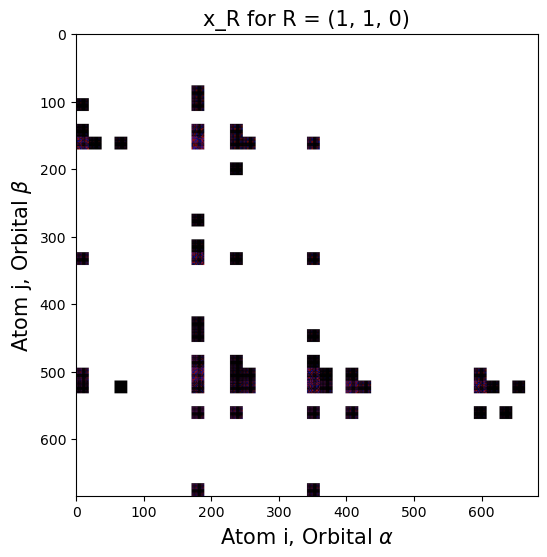

In [35]:
import matplotlib.pyplot as plt
from colorsys import hls_to_rgb
def colorize(z):
    r = np.abs(z)
    arg = np.angle(z)
    h = 0.67 - 0.67 * np.sign(arg) * np.abs(arg) / np.pi  # Blue to Red
    l = np.where(r > 0, 1.0 - 1.0 / (1.0 + r**0.3), 1.0)
    s = 0.8  # Set saturation constant
    
    # Convert HLS to RGB
    c = np.array([hls_to_rgb(h_i, l_i, s) for h_i, l_i in zip(h.flat, l.flat)])
    c = c.reshape(h.shape + (3,))
    
    return c

# for key in Rx_R:
#     img = colorize(Rx_R[key])
#     plt.figure(figsize=(8, 6))
#     # Plot the image
#     plt.imshow(img)
#     plt.xlabel('Atom i, Orbital $\\alpha$',fontsize=15)
#     plt.ylabel('Atom j, Orbital $\\beta$',fontsize=15)   
#     plt.title('x_R for R = {}'.format(key),fontsize=15)
#     plt.show()
    
key = (1,1,0)
img = colorize(Rx_R[key])
plt.figure(figsize=(8, 6))
# Plot the image
plt.imshow(img)
plt.xlabel('Atom i, Orbital $\\alpha$',fontsize=15)
plt.ylabel('Atom j, Orbital $\\beta$',fontsize=15)   
plt.title('x_R for R = {}'.format(key),fontsize=15)
plt.show()